In [ ]:
!pip install gradio

# AI or NOT GRADIO

In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model_paths = {
    "vgg16_model": '/content/drive/MyDrive/final/AiOrNot/vgg16_val.h5',
    "resnet50": '/content/drive/MyDrive/final/AiOrNot/resnet50.h5',
    "inception": '/content/drive/MyDrive/final/AiOrNot/inceptionv3_.h5',
}

class_names = ['Fake', 'Real']

def predict_image_vgg(img_array, selected_model):
    try:
        if img_array is None:
            return "No image provided."

        if img_array.ndim == 2:
            img_array = np.expand_dims(img_array, axis=-1)

        if selected_model == "inception":
            img_array = image.array_to_img(img_array)
            img_array = img_array.resize((75, 75))
            img_array = image.img_to_array(img_array) / 255.0
        else:
            img_array = image.array_to_img(img_array)
            img_array = img_array.resize((32, 32))
            img_array = image.img_to_array(img_array) / 255.0

        img_array = np.expand_dims(img_array, axis=0)

        model_path = model_paths.get(selected_model)
        if model_path is None:
            return "Invalid model selection."

        model = load_model(model_path)

        predictions = model.predict(img_array)
        predicted_class = (predictions > 0.51).astype("int32")

        return class_names[predicted_class[0][0]]
    except Exception as e:
        return str(e)

iface = gr.Interface(
    fn=predict_image_vgg,
    inputs=["image", gr.Dropdown(list(model_paths.keys()), label="Select Model")],
    outputs="text"
)

iface.launch()


# Sevirity GRADIO

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from io import BytesIO

# Define class mapping for severity levels
class_mapping = {0: 'minor', 1: 'moderate', 2: 'severe'}

# Load all four models
models = {
    "sev_vgg16": load_model('/content/drive/MyDrive/final/best_vgg16_model.h5'),
    "sev_resnet50": load_model('/content/drive/MyDrive/final/sevirity/ResNet50_sev (1).h5'),
    #"sev_effici": load_model('/content/drive/MyDrive/final/sevirity/efficentnent_sev.h5'),
    "sev_inception": load_model('/content/drive/MyDrive/final/sevirity/inceptionv3_sev.h5'),
}

def predict(img_array, selected_model):
    try:
        img = image.array_to_img(img_array)
        if selected_model == "sev_inception":
            img = img.resize((299, 299))
        else:
            img = img.resize((224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.

        model = models.get(selected_model)
        if model is None:
            return "Invalid model selection."

        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions)
        predicted_severity = class_mapping[predicted_class_index]

        return f"Predicted severity for {selected_model}: {predicted_severity}"

    except Exception as e:
        return str(e)

iface = gr.Interface(
    fn=predict,
    inputs=["image", gr.Dropdown(list(models.keys()), label="Select Model")],
    outputs="text"
)

iface.launch()


# SI DI

In [ ]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 3.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-f1n0cq_y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-f1n0cq_y
  Resolved https://github.com/facebookresearch/detectron2.git to commit 864913f0e57e87a75c8cc0c7d79ecbd774fc669b


In [ ]:
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# Define your custom class names here
CUSTOM_CLASS_NAMES = ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']

def register_custom_dataset():
    # Here you should register your custom dataset if it hasn't been registered yet.
    # Since you haven't provided how your dataset is loaded,
    # I will assume it is already registered in DatasetCatalog under "my_dataset_train" and "my_dataset_val"
    for d in ["train", "val"]:
        MetadataCatalog.get(f"my_dataset_{d}").set(thing_classes=CUSTOM_CLASS_NAMES)
    return MetadataCatalog.get("my_dataset_train")

def setup_cfg():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS ="/content/drive/MyDrive/final/model_final.pth"
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CUSTOM_CLASS_NAMES)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # Set a low threshold to display more predictions
    cfg.DATASETS.TRAIN = ("my_dataset_train",)
    cfg.DATASETS.TEST = ("my_dataset_val",)
    cfg.freeze()
    return cfg

def load_image(image_path):
    return cv2.imread(image_path)

def predict(image, cfg):
    predictor = DefaultPredictor(cfg)
    return predictor(image)

def filter_predictions_by_confidence(instances, min_confidence, max_confidence):
    confidence_indices = (instances.scores > min_confidence) & (instances.scores <= max_confidence)
    return instances[confidence_indices]

def visualize(image, predictions, metadata):
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)
    v = v.draw_instance_predictions(predictions.to("cpu"))
    result_image = v.get_image()[:, :, ::-1]
    return result_image

def main(image_path):
    cfg = setup_cfg()
    metadata = register_custom_dataset()
    image = load_image(image_path)
    outputs = predict(image, cfg)

    # Get the highest score to set the threshold
    highest_score = outputs['instances'].scores.max().item() if len(outputs['instances']) else 0
    threshold = highest_score * (2/3)  # Calculate 2/3 of the highest score

    # Filter predictions by confidence
    confidence_instances = filter_predictions_by_confidence(outputs['instances'], threshold, 1.0)

    # Visualize the predictions
    result_image = visualize(image, confidence_instances, metadata)

    # Display the image
    cv2_imshow(result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()




In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!unzip /content/drive/MyDrive/Data_Firas_ben_hassen/data.zip

Archive:  /content/drive/MyDrive/Data_Firas_ben_hassen/data.zip
  inflating: test2017/000012.jpg     
  inflating: test2017/000015.jpg     
  inflating: test2017/000023.jpg     
  inflating: test2017/000033.jpg     
  inflating: test2017/000040.jpg     
  inflating: test2017/000042.jpg     
  inflating: test2017/000044.jpg     
  inflating: test2017/000057.jpg     
  inflating: test2017/000082.jpg     
  inflating: test2017/000088.jpg     
  inflating: test2017/000090.jpg     
  inflating: test2017/000106.jpg     
  inflating: test2017/000128.jpg     
  inflating: test2017/000152.jpg     
  inflating: test2017/000165.jpg     
  inflating: test2017/000175.jpg     
  inflating: test2017/000185.jpg     
  inflating: test2017/000191.jpg     
  inflating: test2017/000204.jpg     
  inflating: test2017/000214.jpg     
  inflating: test2017/000224.jpg     
  inflating: test2017/000233.jpg     
  inflating: test2017/000237.jpg     
  inflating: test2017/000253.jpg     
  inflating: test2017/00

In [ ]:
!unrar x /content/drive/MyDrive/Data_Firas_ben_hassen/annotations.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Data_Firas_ben_hassen/annotations.rar

Creating    annotations                                               OK
Extracting  annotations/convert-format.py                                  0%  OK 
Extracting  annotations/image_info.xlsx                                    5%  OK 
Extracting  annotations/instances_test2017.json                           14%  OK 
Extracting  annotations/instances_train2017.json                          80%  OK 
Extracting  annotations/instances_val2017.json                            99%  OK 
All OK


In [ ]:
from detectron2.data.datasets import register_coco_instances

train_annot = "/content/annotations/instances_train2017.json"
train_img = "/content/train2017"
val_annot = "/content/annotations/instances_val2017.json"
val_img = "/content/val2017r"

register_coco_instances("my_dataset_train", {}, train_annot, train_img)
register_coco_instances("my_dataset_val", {}, val_annot, val_img)


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import os
import numpy as np
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Load the pre-trained model config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")



In [ ]:
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # set number of classes in your dataset


In [ ]:
cfg.OUTPUT_DIR="/content/drive/MyDrive/Acvops"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
# trainer.train()


[01/22 12:17:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:01, 219MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


[01/22 12:17:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/final/model_final.pth ...
Label: dent, Score: 0.75
Label: dent, Score: 0.56


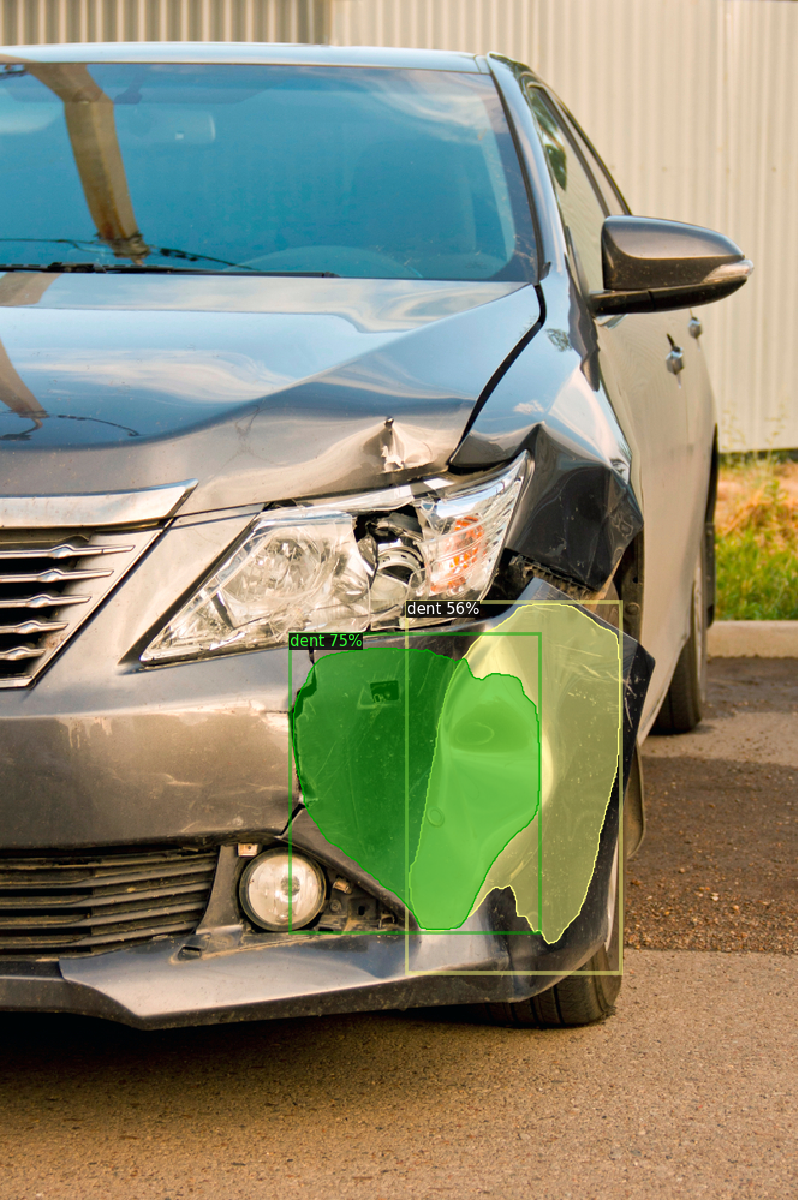

In [ ]:
cfg.MODEL.WEIGHTS ="/content/drive/MyDrive/final/model_final.pth"
from detectron2.engine import DefaultPredictor
# Load an image
from google.colab.patches import cv2_imshow

image_path = "/content/test2017/000191.jpg"
im = cv2.imread(image_path)
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

# Extract predictions within a specific confidence range
instances = outputs["instances"]
min_confidence = 0.45  # 30%
max_confidence = 1  # 70%
confidence_indices = (instances.scores > min_confidence) & (instances.scores < max_confidence)
confidence_instances = instances[confidence_indices]

# Get class labels and scores for predictions in the confidence range
class_labels = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
predicted_classes = confidence_instances.pred_classes.tolist()
predicted_scores = confidence_instances.scores.tolist()

# Print out the labels with their scores
for class_index, score in zip(predicted_classes, predicted_scores):
    label = class_labels[class_index]
    print(f"Label: {label}, Score: {score:.2f}")

# Visualize the predictions within the confidence range (optional visualization step)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(confidence_instances.to("cpu"))
result_image = v.get_image()[:, :, ::-1]

# Display the image in Colab (optional visualization step)
cv2_imshow(result_image)



In [ ]:
# import gradio as gr
# import cv2
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# import numpy as np
# import sys
# from detectron2.config import get_cfg
# from detectron2.engine import DefaultPredictor
# from detectron2.data import MetadataCatalog
# from detectron2.utils.visualizer import Visualizer

# # Dictionary mapping model names to their corresponding file paths
# model_paths = {
#     "vgg16_model": '/content/drive/MyDrive/final/AiOrNot/vgg16_val.h5',
#     "resnet50": '/content/drive/MyDrive/final/AiOrNot/resnet50.h5',
#     "inception": '/content/drive/MyDrive/final/AiOrNot/inceptionv3_.h5',
#     "segmentation_model": "/content/drive/MyDrive/final/model_final.pth",
# }

# class_names = ['Fake', 'Real']

# def predict_segmentation(img_array):
#     try:
#         if img_array is None:
#             return "No image provided."
#         print("got here")
#         if img_array.ndim == 2:
#             img_array = np.expand_dims(img_array, axis=-1)
#         sys.stderr.write("cfg will enter")
#         # Perform segmentation task
#         cfg = get_cfg()
#         cfg.MODEL.WEIGHTS = model_paths["segmentation_model"]
#         predictor = DefaultPredictor(cfg)
#         print("now i go outpts")
#         # Perform segmentation
#         outputs = predictor(img_array)
#         instances = outputs["instances"]
#         print("v")
#         # Visualize the segmentation result (optional visualization step)
#         v = Visualizer(img_array[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#         v = v.draw_instance_predictions(instances.to("cpu"))
#         result_image = v.get_image()[:, :, ::-1]

#         # Convert result_image to Gradio's Image format
#         result_image_gr = gr.Image(result_image)

#         return result_image_gr

#     except Exception as e:
#         print("Error during segmentation:", str(e))
#         return "Error during segmentation."


# # # Define the Gradio interfaces
# # classification_interface = gr.Interface(
# #     fn=predict_classification,
# #     inputs=["image", gr.Dropdown(["vgg16_model", "resnet50", "inception"], label="Select Classification Model")],
# #     outputs="text"
# # )

# segmentation_interface = gr.Interface(
#     fn=predict_segmentation,
#     inputs="image",
#     outputs="image"
# )

# # Launch the interfaces
# # classification_interface.launch()
# segmentation_interface.launch()


In [ ]:
# import gradio as gr
# import cv2
# import numpy as np
# from detectron2.config import get_cfg
# from detectron2.engine import DefaultPredictor
# from detectron2.data import MetadataCatalog
# from detectron2.utils.visualizer import Visualizer

# model_path = "/content/drive/MyDrive/final/model_final.pth"

# def predict_segmentation(img_array):
#     try:
#         if img_array is None:
#             return "No image provided."

#         if img_array.ndim == 2:
#             img_array = np.expand_dims(img_array, axis=-1)

#         # Perform segmentation task
#         cfg = get_cfg()
#         cfg.MODEL.WEIGHTS = model_path
#         predictor = DefaultPredictor(cfg)

#         # Perform segmentation
#         outputs = predictor(img_array)
#         instances = outputs["instances"]

#         # Extract predictions within a specific confidence range
#         min_confidence = 0.45
#         max_confidence = 1
#         confidence_indices = (instances.scores > min_confidence) & (instances.scores < max_confidence)
#         confidence_instances = instances[confidence_indices]

#         # Get class labels and scores for predictions in the confidence range
#         class_labels = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes if len(cfg.DATASETS.TRAIN) > 0 else []

#         # Debugging: print the value of cfg.DATASETS.TRAIN
#         print("cfg.DATASETS.TRAIN:", cfg.DATASETS.TRAIN)

#         # Check if there are any class labels
#         if not class_labels:
#             return "No class labels available."

#         predicted_classes = confidence_instances.pred_classes.tolist()
#         predicted_scores = confidence_instances.scores.tolist()

#         # Print out the labels with their scores
#         for class_index, score in zip(predicted_classes, predicted_scores):
#             label = class_labels[class_index]
#             print(f"Label: {label}, Score: {score:.2f}\n")

#         # Visualize the predictions within the confidence range (optional visualization step)
#         # Debugging: print the length of cfg.DATASETS.TRAIN
#         print("len(cfg.DATASETS.TRAIN):", len(cfg.DATASETS.TRAIN))

#         v = Visualizer(img_array[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#         v = v.draw_instance_predictions(confidence_instances.to("cpu"))
#         result_image = v.get_image()[:, :, ::-1]

#         # Convert result_image to Gradio's Image format
#         result_image_gr = gr.Image(result_image)

#         return result_image_gr

#     except Exception as e:
#         print("Error during segmentation: {}\n".format(str(e)))
#         raise  # Re-raise the exception to see the full traceback

# # Define the Gradio interface
# iface = gr.Interface(
#     fn=predict_segmentation,
#     inputs="image",
#     outputs="image"
# )

# # Launch the interface
# iface.launch(debug=True)  # Adding `share=True` allows the cell to keep working


In [ ]:
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# Define your custom class names here
CUSTOM_CLASS_NAMES = ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']

def register_custom_dataset():
    # Here you should register your custom dataset if it hasn't been registered yet.
    # Since you haven't provided how your dataset is loaded,
    # I will assume it is already registered in DatasetCatalog under "my_dataset_train" and "my_dataset_val"
    for d in ["train", "val"]:
        MetadataCatalog.get(f"my_dataset_{d}").set(thing_classes=CUSTOM_CLASS_NAMES)
    return MetadataCatalog.get("my_dataset_train")

def setup_cfg():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/final/model_final.pth"
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CUSTOM_CLASS_NAMES)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # Set a low threshold to display more predictions
    cfg.DATASETS.TRAIN = ("my_dataset_train",)
    cfg.DATASETS.TEST = ("my_dataset_val",)
    cfg.freeze()
    return cfg

def load_image(image_path):
    return cv2.imread(image_path)

def predict(image, cfg):
    predictor = DefaultPredictor(cfg)
    return predictor(image)

def filter_predictions_by_confidence(instances, min_confidence, max_confidence):
    confidence_indices = (instances.scores > min_confidence) & (instances.scores <= max_confidence)
    return instances[confidence_indices]

def visualize(image, predictions, metadata):
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)
    v = v.draw_instance_predictions(predictions.to("cpu"))
    result_image = v.get_image()[:, :, ::-1]
    return result_image

def main(image_path):
    cfg = setup_cfg()
    metadata = register_custom_dataset()
    image = load_image(image_path)
    outputs = predict(image, cfg)

    # Get the highest score to set the threshold
    highest_score = outputs['instances'].scores.max().item() if len(outputs['instances']) else 0
    threshold = highest_score * (2/3)  # Calculate 2/3 of the highest score

    # Filter predictions by confidence
    confidence_instances = filter_predictions_by_confidence(outputs['instances'], threshold, 1.0)

    # Visualize the predictions
    result_image = visualize(image, confidence_instances, metadata)

    # Display the image
    cv2_imshow(result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# if __name__ == "__main__":
#     import sys

#     # The path to the image file to use for inference
#     image_path = "/content/000301.jpg"
#     main(image_path)


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import os
import numpy as np
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Load the pre-trained model config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")



In [ ]:
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # set number of classes in your dataset


In [ ]:
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/final/model_final.pth"
from detectron2.engine import DefaultPredictor
# Load an image
from google.colab.patches import cv2_imshow
image_path = "/content/val2017/003962.jpg"  # Update this path

def predict_seg(img_path):
  im = cv2.imread(image_path)
  print(type(im))
  predictor = DefaultPredictor(cfg)
  outputs = predictor(im)

# Extract predictions within a specific confidence range
  instances = outputs["instances"]
  min_confidence = 0.3  # 30%
  max_confidence = 0.7  # 70%
  confidence_indices = (instances.scores > min_confidence) & (instances.scores < max_confidence)
  confidence_instances = instances[confidence_indices]

# Get class labels and scores for predictions in the confidence range
  # class_labels = MetadataCatalog.get(cfg.DATASETS.TEST[0]).thing_classes
  predicted_classes = confidence_instances.pred_classes.tolist()
  predicted_scores = confidence_instances.scores.tolist()

# Print out the labels with their scores
  for class_index, score in zip(predicted_classes, predicted_scores):
      label = class_labels[class_index]
      print(f"Label: {label}, Score: {score:.2f}")
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
  v = v.draw_instance_predictions(confidence_instances.to("cpu"))
  result_image = v.get_image()[:, :, ::-1]

# Display the image in Colab (optional visualization step)
  return result_image

predict_seg(image_path)


In [ ]:
import gradio as gr
import cv2
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Define the model path
model_path = "/content/drive/MyDrive/final/model_final.pth"

# Load the configuration
cfg = get_cfg()
cfg.MODEL.WEIGHTS = model_path

# Define the custom class names
CUSTOM_CLASS_NAMES = ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']

# Set the number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CUSTOM_CLASS_NAMES)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

# Function for prediction
def predict_seg(img):
    # Create predictor
    predictor = DefaultPredictor(cfg)
    outputs = predictor(img)

    # Extract predictions within a specific confidence range
    instances = outputs["instances"]
    min_confidence = 0.3  # 30%
    max_confidence = 0.7  # 70%
    confidence_indices = (instances.scores > min_confidence) & (instances.scores < max_confidence)
    confidence_instances = instances[confidence_indices]

    # Visualize the result with segmentation masks and bounding boxes
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)

    # Draw segmentation masks and bounding boxes
    v = v.draw_instance_predictions(confidence_instances.to("cpu"))

    # Get the image with drawn segmentation masks and bounding boxes
    result_image = v.get_image()[:, :, ::-1]

    return gr.Image(result_image)

# Define the Gradio interface
iface = gr.Interface(
    fn=predict_seg,
    inputs="image",
    outputs="image",
)

# Launch the interface
iface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f966a2bdd0eb6f20cb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


[01/21 23:27:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/final/model_final.pth ...


backbone.res2.0.conv1.norm.{bias, weight}
backbone.res2.0.conv1.weight
backbone.res2.0.conv2.norm.{bias, weight}
backbone.res2.0.conv2.weight
backbone.res2.0.conv3.norm.{bias, weight}
backbone.res2.0.conv3.weight
backbone.res2.0.shortcut.norm.{bias, weight}
backbone.res2.0.shortcut.weight
backbone.res2.1.conv1.norm.{bias, weight}
backbone.res2.1.conv1.weight
backbone.res2.1.conv2.norm.{bias, weight}
backbone.res2.1.conv2.weight
backbone.res2.1.conv3.norm.{bias, weight}
backbone.res2.1.conv3.weight
backbone.res2.2.conv1.norm.{bias, weight}
backbone.res2.2.conv1.weight
backbone.res2.2.conv2.norm.{bias, weight}
backbone.res2.2.conv2.weight
backbone.res2.2.conv3.norm.{bias, weight}
backbone.res2.2.conv3.weight
backbone.res3.0.conv1.norm.{bias, weight}
backbone.res3.0.conv1.weight
backbone.res3.0.conv2.norm.{bias, weight}
backbone.res3.0.conv2.weight
backbone.res3.0.conv3.norm.{bias, weight}
backbone.res3.0.conv3.weight
backbone.res3.0.shortcut.norm.{bias, weight}
backbone.res3.0.shortcut.w